Coda energy plot
====

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import numpy as np
from scipy.signal import hilbert
from sbp_modelling.single_source_deep.model import SingleSourceModel, v_p_0, v_p_1
from sbp_modelling.single_source_deep.analysis import depth_to_time, waterbottom, mtd_top, mtd_base
from sbp_modelling.single_source_deep.forward_model import f_0
from sbp_modelling.analysis import envelope
import pandas as pd
import matplotlib.transforms as transforms
import matplotlib.ticker as ticker
from cycler import cycler
from collections import defaultdict
from examples.seismic import RickerSource, TimeAxis
from string import ascii_lowercase
from matplotlib.cm import get_cmap

plt.style.use('./mpl/manuscript.mplstyle')
aspect = 1.25
plt.rcParams['figure.figsize'][1] = plt.rcParams['figure.figsize'][0] * aspect

SBP_CACHE_PATH unset


Operator `initdamp` ran in 0.03 s
Operator `pad_lam` ran in 0.01 s
Operator `pad_mu` ran in 0.01 s
Operator `pad_b` ran in 0.01 s


400
SBP_CACHE_PATH unset
Loaded from cache /tmp/sbp_006205807092339b78e01c2d30789693.npz
65.60786816519489


In [2]:
results_path = '../../results/single-source-deep/traces.npz'
csv_path = '../../results/single-source-deep/rms-amplitudes.csv'

loaded = np.load(results_path)

params = loaded['params']
data_raw = loaded['data'].T
t = loaded['t']

In [3]:
model = SingleSourceModel()
waterbottom, mtd_top, mtd_base = model.horizons()

wb = depth_to_time(waterbottom, offset=True)
t_start = depth_to_time(mtd_top, offset=True)
t_end = depth_to_time(mtd_base, offset=True)

t_ind = (t > t_start) & (t < t_end)
t_ind.shape, t_start, t_end

((9704,), 76.19922730110848, 86.29313669204757)

In [4]:
data = envelope(data_raw)
factor = 1e6 # From Fig. 4
data *= factor

In [5]:
a_z = 0.05
a_x_s = list(np.unique(params[:, 0]))
want_params = (1000, a_z), (100, a_z), (10, a_z), (1, a_z), (0.1, a_z)

In [6]:
df = pd.read_csv(csv_path)

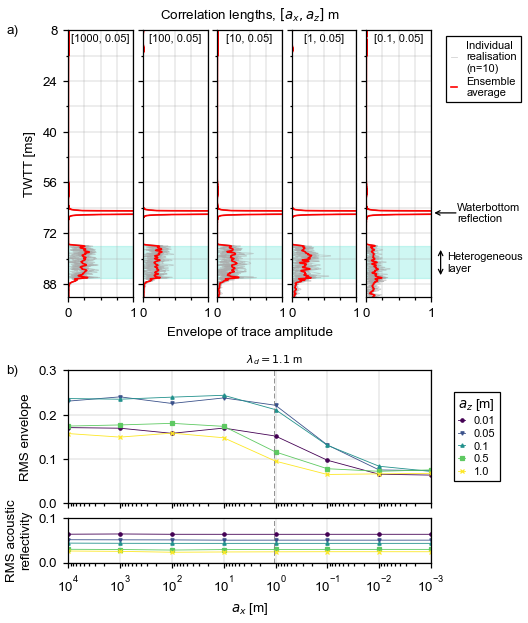

In [7]:
fig = plt.figure(constrained_layout=False)
gs = gridspec.GridSpec(4, len(want_params) + 1, figure=fig,
                       height_ratios=[6, 1, 3, 1],
                       wspace=0.15,
                       hspace=0.15 / aspect
                      )
ax = [None] * (len(want_params) + 1)
for i in range(len(want_params) + 1):
    ax[i] = fig.add_subplot(gs[0, i])
    if i > 0:
        ax[0].get_shared_y_axes().join(ax[0], ax[i])
for i in range(1, len(ax)):
    ax[i].set_yticklabels([])
ax[0].set(ylabel='TWTT [ms]')
ax[-1].axis('off')

ax2 = fig.add_subplot(gs[-2, :-1])
ax3 = fig.add_subplot(gs[-1, :-1])
top_text = fig.add_subplot(gs[0, :-1])
top_text.axis('off')

ax2_legend = fig.add_subplot(gs[-2, -1])

plt.setp(ax2.get_xticklabels(), visible=False)

amp_set = False

for i, (a_x, a_z) in enumerate(want_params):
    ax[i].annotate(f'[{round(a_x, 2)}, {round(a_z, 2)}]', xy=(0.5, 1), xytext=(0, -2),
        xycoords='axes fraction', textcoords='offset points', ha='center', va='top', fontsize='small')

    ind = (params[:, 0] == a_x) & (params[:, 1] == a_z)
    n = np.sum(ind)

    if n == 0:
        # If we don't find any run with these parameters, skip
        continue
        
    ax[i].axhspan(t_start, t_end, color='turquoise', alpha=0.25, zorder=-999)

    ax[i].plot(data[:, ind], t, color='darkgray', alpha=0.5, linewidth=0.5,
               label='Individual\nrealisation\n(n={})'.format(data[:, ind].shape[1]))
    ax[i].plot(np.sqrt(np.square(data[:, ind]).mean(axis=1)), t, linewidth=1.0,
               color='red', label='Ensemble\naverage')

    ax[i].set(ylim=(8, 92), xlim=(0, 1), yticks=np.arange(8, 92, 16)) # lim
    ax[i].invert_yaxis()
    ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].grid('on', which='both')

handles, labels = ax[i].get_legend_handles_labels()
handles[0] = Line2D([0], [0], color='darkgray', lw=0.75)
by_label = dict(zip(labels, handles))
ax[-1].legend(by_label.values(), by_label.keys(), title='', loc='upper left',
              frameon=True, framealpha=1., edgecolor='k', fancybox=False, fontsize='small')

ax[-1].annotate('Heterogeneous\nlayer', xy=(0.1, (t_start + t_end) / 2), xytext=(0, 0),
               textcoords='offset points', ha='left', va='center', fontsize='small')
ax[-1].annotate('', xy=(0, t_start), xytext=(0, t_end),
                textcoords='data', arrowprops=dict(arrowstyle='<->'), fontsize='small')

ax[-1].annotate('Waterbottom\nreflection', xy=(0.25, wb), xytext=(0, 0),
               textcoords='offset points', ha='left', va='center', fontsize='small')
ax[-2].annotate('', xy=(1, wb), xytext=(17, 0),
                textcoords='offset points', arrowprops=dict(arrowstyle='->'), fontsize='small')

ax[2].set_xlabel('Envelope of trace amplitude', ha='center')
ax[2].annotate('Correlation lengths, $[a_x, a_z]$ m', xy=(0.5, 1), xytext=(0, 4),
    xycoords='axes fraction', textcoords='offset points', va='bottom', ha='center')

cmap = get_cmap('viridis')
custom_cycler = (cycler('color', cmap(np.linspace(0, 1, 5))) +
    cycler('marker', ['o', 'v', '^', 's', 'x']))
ax2.set_prop_cycle(custom_cycler)
ax3.set_prop_cycle(custom_cycler)

finite_iter = iter(custom_cycler)
styles = defaultdict(lambda: next(finite_iter))
default_style = {
    'alpha': 1.0,
    'markersize': 2,
    'linewidth': 0.5,
}

for a_z in df['a_z'].unique():
    ind = df['a_z'] == a_z
    one_line = df.loc[df['a_z'] == a_z].groupby('a_x').mean()
    ax2.plot(
        one_line['rms_amplitude'] * factor,
        label=f'{round(a_z, 2)}',
        **default_style
    )
    ax3.plot(
        one_line['rms_reflectivity'],
        **default_style
    )

ax2.set(ylabel='RMS envelope', ylim=[0.0, 0.3])
ax3.set(xlabel='$a_x$ [m]', ylabel='RMS acoustic\nreflectivity', ylim=[0, 0.1])

for a in ax2, ax3:
    a.set(xscale='log',
           xlim=[df['a_x'].min(), df['a_x'].max()])
    a.grid('on')
    a.invert_xaxis()
    

handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax2_legend.legend(by_label.values(), by_label.keys(), title='$a_z$ [m]',
                  loc='center right', fontsize='small')

ax2_legend.axis('off')

wavelength = (v_p_0 + v_p_1) / (2 * f_0)

for text, position in (f'$\lambda_d={wavelength:.2g}$ m', wavelength),:
    ax2.annotate(text, xy=(position, 1), xytext=(0, 2), textcoords='offset points', ha='center', va='bottom',
         xycoords=transforms.blended_transform_factory(ax2.transData, ax2.transAxes), fontsize='small')
    for a in ax2, ax3:
        a.axvline(position, color='grey', linestyle='dashed', dashes=(6, 3), linewidth=0.5)


def label_axis(axis, i, offset=(-30, 0)):
    axis.annotate(f'{ascii_lowercase[i]})', xy=(0, 1), xytext=offset,
                   textcoords='offset points', xycoords='axes fraction', va='center', ha='right')
    
for i, a in enumerate([ax[0], ax2]):
    label_axis(a, i)

In [8]:
a = df.groupby('a_z')['rms_reflectivity']
100 * (a.max() - a.min()) / a.min()

a_z
0.01     1.178222
0.05     1.969743
0.10     1.301521
0.50     6.200738
1.00    11.975755
Name: rms_reflectivity, dtype: float64

In [9]:
fig.savefig('../../manuscript/figures/si_fig12.pdf')